# Explainable AI (XAI) SHAP on Images

## SHAP Values for Image Classification Tasks

* Deep learning models like convolutional neural networks are giving quite good results at many computer vision tasks. 
* We need to understand that the models that are giving such high accuracy are predicting results based on data parts that they should use for prediction.
* Let's say for example that we have an image classification task of predicting cat vs dog then the model should look at pixels of face and body of cat/dog to predict class, not the background pixels of images should be used to make a decision. 
* If that is the case then we can be sure that our model has generalized better and actually learning features of cats and dogs. 
* SHAP is a python library that generates shap values for predictions using a game-theoretic approach. We can then visualize these shap values using various visualizations to understand which features contributed to prediction.

### Importing section

In [13]:
import tensorflow
from tensorflow import keras
print("Keras Version : {}".format(keras.__version__))
#! pip install shap
import shap
print("SHAP Version : {}".format(shap.__version__))
from tensorflow import keras
from sklearn.model_selection import train_test_split
from jax import numpy as jnp
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Keras Version : 2.8.0
SHAP Version : 0.41.0


## Loading Data

we have loaded the Fashion MNIST dataset available from keras. The dataset has grayscale images of shape (28,28) pixels for 10 different fashion items. The dataset is already divided into the train (60k images) and test (10k images) sets. Below we have mapping from index to fashion item names.

                        Label 	Description
                        0 	T-shirt/top
                        1 	Trouser
                        2 	Pullover
                        3 	Dress
                        4 	Coat
                        5 	Sandal
                        6 	Shirt
                        7 	Sneaker
                        8 	Bag
                        9 	Ankle boot

In [4]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_test = X_train.reshape(-1,28,28,1), X_test.reshape(-1,28,28,1)

X_train, X_test = X_train/255.0, X_test/255.0

classes =  np.unique(Y_train)
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
mapping = dict(zip(classes, class_labels))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

## Lets Define a CNN for the image classification

lets define a convolutional neural network that we'll use to classify images of the Fashion MNIST dataset loaded earlier. The network is simple with 2 convolution layers and one dense layer. The two convolution layers have filters 32 and 16 respectively and both are using kernel size of (3,3). We have applied relu (rectified linear unit) activation after both convolution layers. The output of the second convolution layer is flattened and then given to the dense layer. The dense layer has 10 output units, the same as the number of target classes.

In [6]:
model = Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"),

    layers.Flatten(),
    layers.Dense(len(classes), activation="softmax")
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 10)                125450    
                                                                 
Total params: 130,394
Trainable params: 130,394
Non-trainable params: 0
_________________________________________________________________


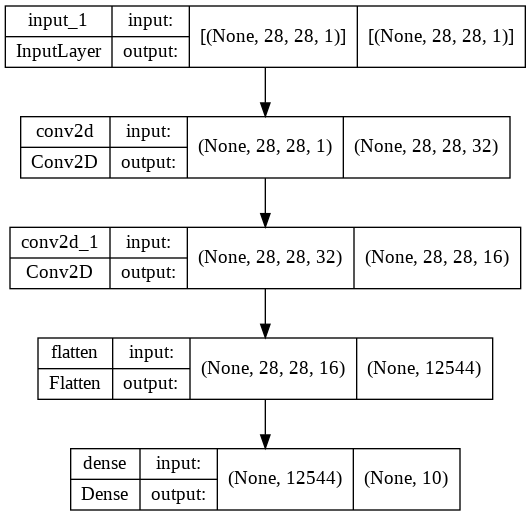

In [11]:
plot_model(model, to_file="basecnnmodel.png", show_shapes=True)

## Lets compile and train the model

lets use Adam optimizer, cross entropy loss, and accuracy metric. Then, train the model for 10 epochs using train and validation data.

In [12]:
model.compile("adam", "sparse_categorical_crossentropy", ["accuracy"])
model.fit(X_train, Y_train, batch_size=256, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
235/235 [==============================] - 10s 7ms/step - loss: 0.5319 - accuracy: 0.8148 - val_loss: 0.4032 - val_accuracy: 0.8573
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.3465 - accuracy: 0.8784 - val_loss: 0.3437 - val_accuracy: 0.8786
Epoch 3/10
235/235 [==============================] - 1s 6ms/step - loss: 0.3057 - accuracy: 0.8903 - val_loss: 0.3276 - val_accuracy: 0.8802
Epoch 4/10
235/235 [==============================] - 1s 6ms/step - loss: 0.2763 - accuracy: 0.9003 - val_loss: 0.3127 - val_accuracy: 0.8895
Epoch 5/10
235/235 [==============================] - 1s 6ms/step - loss: 0.2556 - accuracy: 0.9077 - val_loss: 0.3019 - val_accuracy: 0.8927
Epoch 6/10
235/235 [==============================] - 1s 6ms/step - loss: 0.2357 - accuracy: 0.9154 - val_loss: 0.2909 - val_accuracy: 0.8977
Epoch 7/10
235/235 [==============================] - 1s 6ms/step - loss: 0.2196 - accuracy: 0.9209 - val_loss: 0.2902 - val_accuracy: 0.8990
Epoch

## lets Evaluate Model Performance

* lets evaluate the performance of our network by calculating accuracy, confusion matrix, and classification report (precision, recall, and f1-score per class) metrics. 

* We have used the function available from scikit-learn to calculate various metrics

In [14]:
Y_test_preds = model.predict(X_test)
Y_test_preds = np.argmax(Y_test_preds, axis=1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_test_preds)))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_test, Y_test_preds))
print("\nClassification Report :")
print(classification_report(Y_test, Y_test_preds, target_names=class_labels))


Test Accuracy : 0.9022

Confusion Matrix : 
[[845   1  21  16   5   2 101   0   9   0]
 [  0 985   1   8   2   0   3   0   1   0]
 [ 18   1 875   4  71   1  30   0   0   0]
 [ 19  12  13 883  42   1  28   0   2   0]
 [  1   1  79  14 876   0  28   0   1   0]
 [  0   0   0   1   0 977   0  14   2   6]
 [ 95   3  94  29  91   0 680   0   8   0]
 [  0   0   0   0   0  10   0 965   1  24]
 [  4   1   6   0   4   5   2   3 975   0]
 [  1   0   0   0   0  10   0  28   0 961]]

Classification Report :
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.84      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.80      0.88      0.84      1000
       Dress       0.92      0.88      0.90      1000
        Coat       0.80      0.88      0.84      1000
      Sandal       0.97      0.98      0.97      1000
       Shirt       0.78      0.68      0.73      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag 

## lets explain results using SHAP Partition

In [15]:
shap.initjs()
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)
explainer = shap.Explainer(model, masker, output_names=class_labels)
explainer

## lets Visualize SHAP Values For Correct Predictions

In [17]:
shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])
print(shap_values.shape)
print("Actual Labels    : {}".format([mapping[i] for i in Y_test[:4]]))
probs = model.predict(X_test[:4])
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

(4, 28, 28, 1, 5)
Actual Labels    : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
Predicted Labels : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
Probabilities : [0.99763274 0.99810034 0.9999974  0.9999999 ]


### lets plot the image

lets generate image plots that visualizes shap values generated by the explainer object.

Below, we have generated the first image plot using shap values generated in previous cells. The chart shows the actual image and parts of it highlighted in shades of red and blue colors. The shades of red color show parts that contributed positively and shades of blue color show parts that contributed negatively to the prediction of that category. It also shows the first five categories that the model thinks the image belongs to.

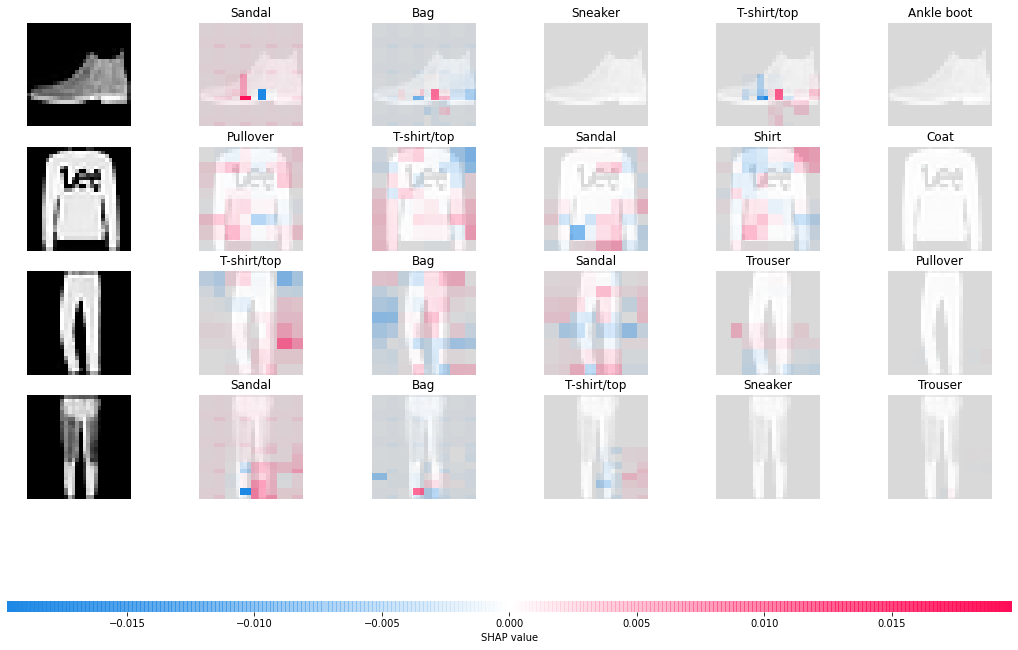

In [19]:
shap.image_plot(shap_values)

lets recreate another image plot using a different masker named inpaint_ns. We have created masker and explainer instances for this again.

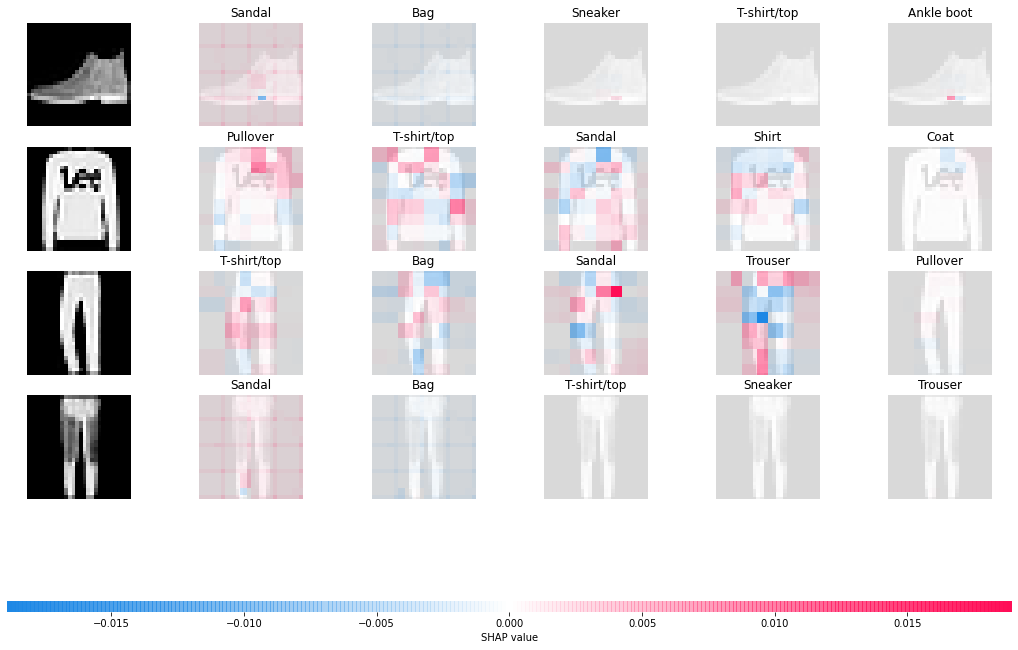

In [20]:
masker = shap.maskers.Image("inpaint_ns", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

Below, we have generated another image plot using masker that uses blurring-based masker. We can notice that the blurring masker seems to be doing a good job compared to other maskers. The tuple of integer values that we provide in the string of masker is the size of the kernel used to blur.

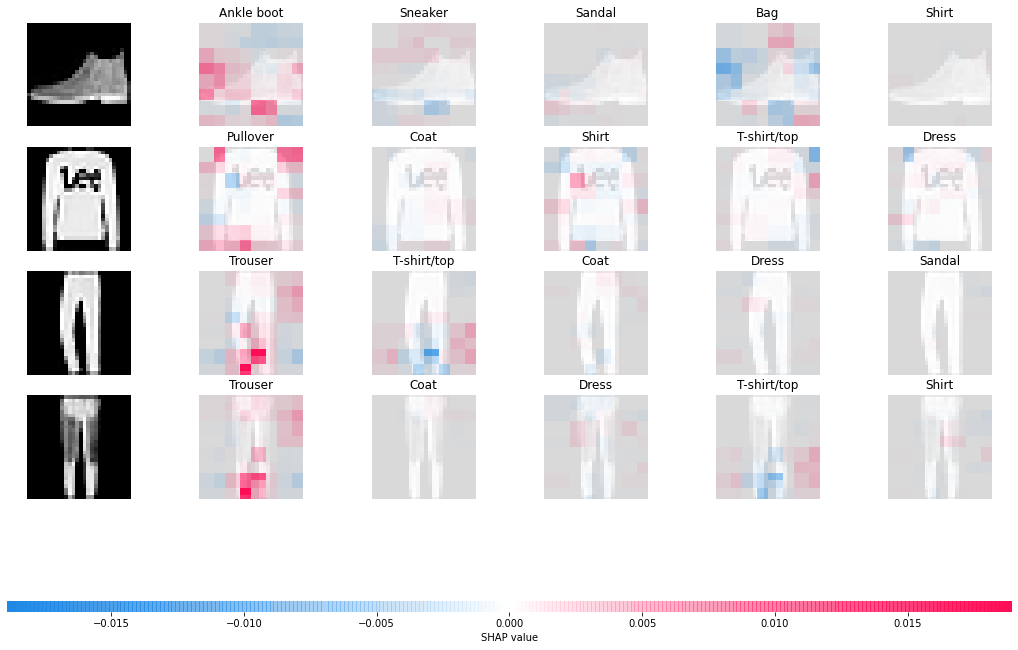

In [21]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

## Now lets visualize SHAP values for Incorrect Predictions

lets explain wrong predictions using the explainer object. In order to explain wrong predictions, we have to first retrieve indexes of all wrong predictions from the test set. Then, we have used indexes of wrong predictions to retrieve those samples and make predictions on them again to retrieve the probabilities of the model for those predictions.

In [23]:
wrong_preds_idx = np.argwhere(Y_test!=Y_test_preds)

X_batch = X_test[wrong_preds_idx.flatten()[:4]]
Y_batch = Y_test[wrong_preds_idx.flatten()[:4]]

print("Actual Labels    : {}".format([mapping[i] for i in Y_batch]))
probs = model.predict(X_batch)
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['Sneaker', 'Ankle boot', 'Coat', 'Dress']
Predicted Labels : ['Bag', 'Sandal', 'Pullover', 'Trouser']
Probabilities : [0.7406467  0.9998412  0.49664924 0.4227529 ]


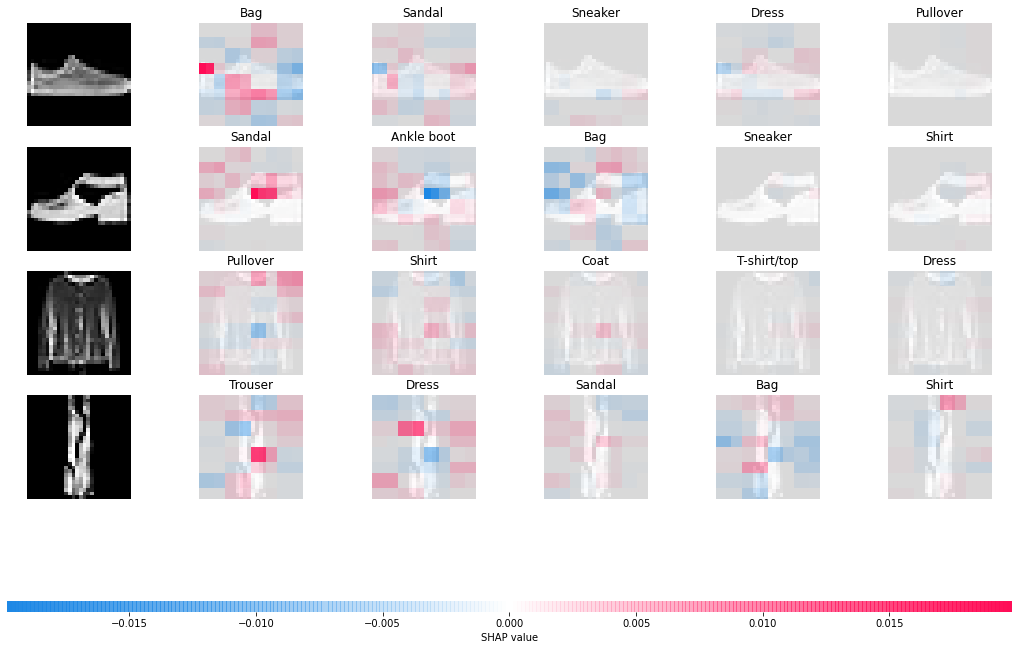

In [24]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

shap_values = explainer(X_batch, outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

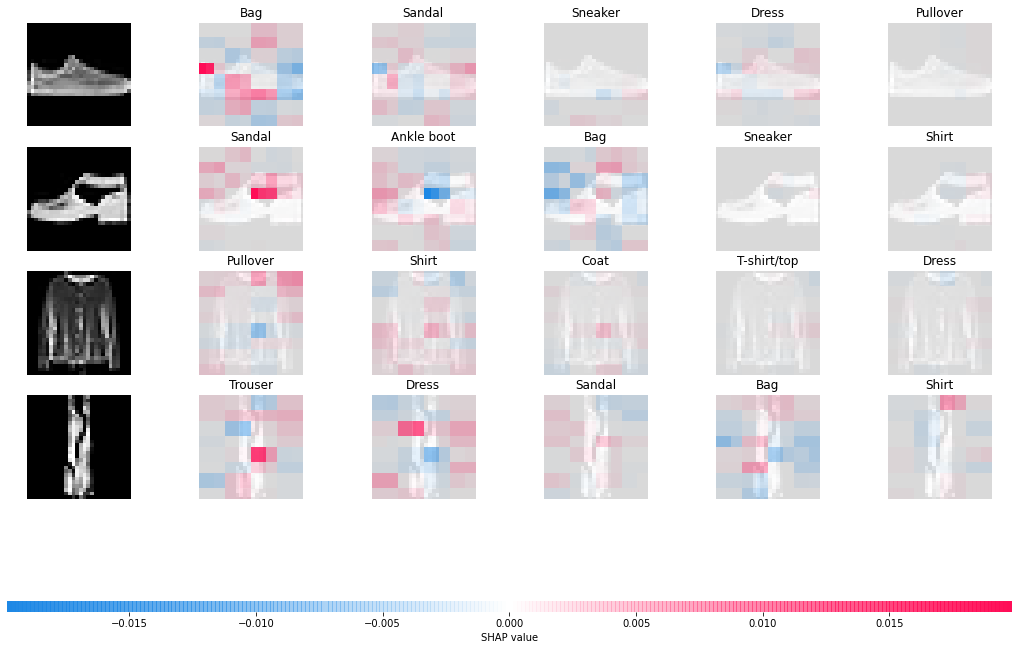

In [25]:
shap.plots.image(shap_values)

## lets try SHAP Permutation Explainer

* lets try another explainer available from a shap named permutation explainer. 
* The permutation explainer can be created using PermutationExplainer() constructor and accepts the same parameters as the shap explainer. 
* The permutation explainer tries different combinations of features to generate shap values.

In [26]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.PermutationExplainer(model, masker, output_names=class_labels)

explainer

<shap.explainers._permutation.Permutation.__init__.<locals>.Permutation at 0x7f0a593a4450>

## Lets visualize SHAP Values For Correct Predictions

lets generate shap values for 4 test images using the permutation explainer object. In the next cell, lets print actual labels, predicted labels, and probabilities of those 4 sample images. lets calculate labels according to the 10 probabilities generated by our model.

(4, 28, 28, 1, 10)
Actual Labels    : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
Predicted Labels : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
Probabilities : [0.99763274 0.99810034 0.9999974  0.9999999 ]
[['Ankle boot' 'Sneaker' 'Sandal' 'Bag' 'Shirt' 'Pullover' 'Coat'
  'T-shirt/top' 'Dress' 'Trouser']
 ['Pullover' 'Coat' 'Shirt' 'T-shirt/top' 'Dress' 'Bag' 'Trouser'
  'Ankle boot' 'Sandal' 'Sneaker']
 ['Trouser' 'T-shirt/top' 'Coat' 'Dress' 'Sandal' 'Bag' 'Shirt'
  'Pullover' 'Ankle boot' 'Sneaker']
 ['Trouser' 'Coat' 'Dress' 'T-shirt/top' 'Shirt' 'Ankle boot' 'Sandal'
  'Bag' 'Pullover' 'Sneaker']]


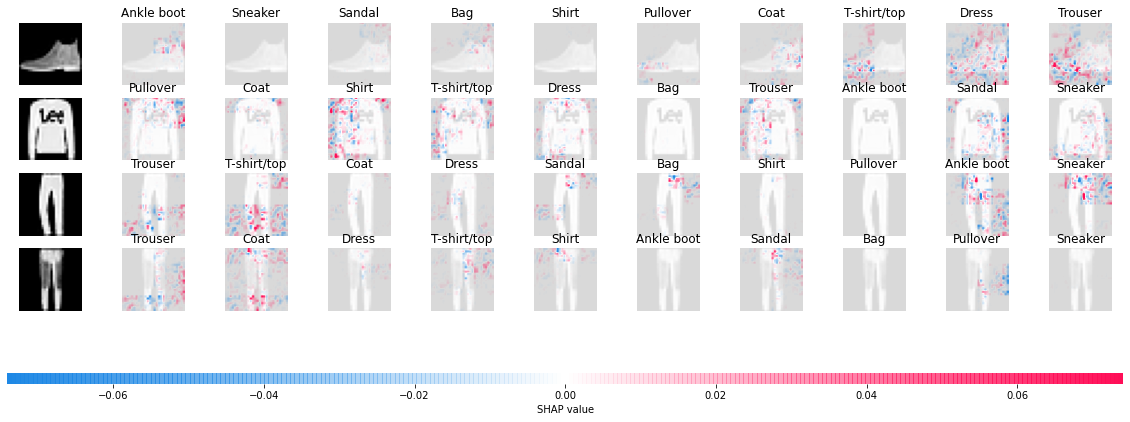

In [29]:
shap_values = explainer(X_test[:4], max_evals=1600, outputs=shap.Explanation.argsort.flip[:5])
print(shap_values.shape)
print("Actual Labels    : {}".format([mapping[i] for i in Y_test[:4]]))
probs = model.predict(X_test[:4])
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))
Y_preds = model.predict(X_test[:4])
Y_preds = Y_preds.argsort()[:, ::-1]
Y_labels = [[class_labels[val] for val in row] for row in Y_preds]
Y_labels=np.array(Y_labels)
print(Y_labels)
shap.image_plot(shap_values, labels=Y_labels)

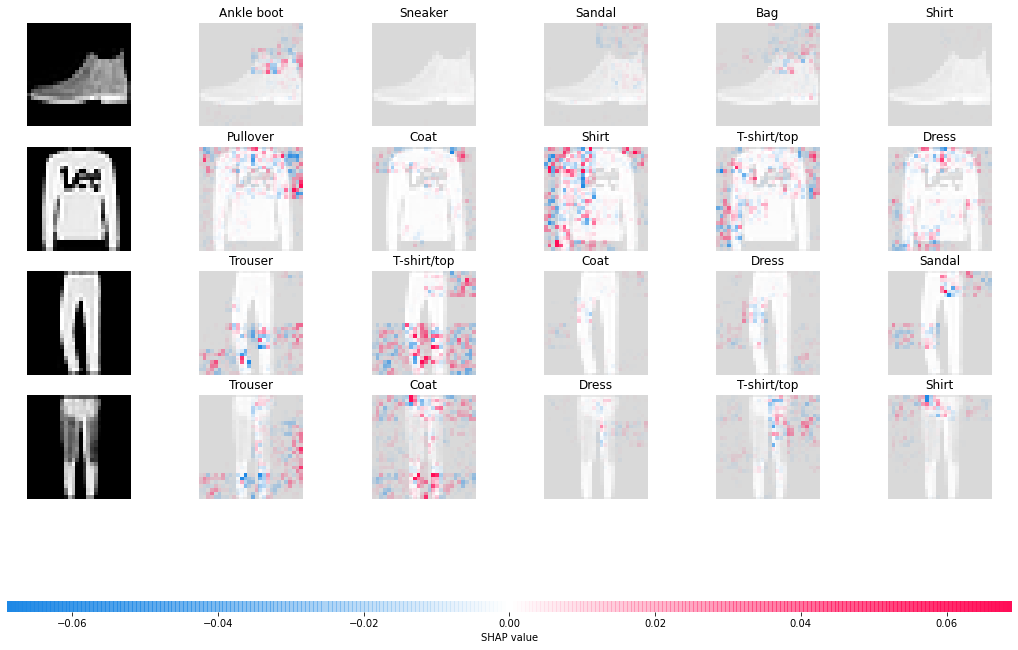

In [30]:
shap.image_plot(shap_values[:,:,:,:,:5], labels=Y_labels[:,:5])

## Lets visualize SHAP Values For In-Correct Predictions

Actual Labels    : ['Sneaker', 'Ankle boot', 'Coat', 'Dress']
Predicted Labels : ['Bag', 'Sandal', 'Pullover', 'Trouser']
Probabilities : [0.7406467  0.9998412  0.49664924 0.4227529 ]
(4, 28, 28, 1, 10)
[['Bag' 'Sandal' 'Sneaker' 'Dress' 'Pullover' 'Ankle boot' 'Shirt'
  'T-shirt/top' 'Trouser' 'Coat']
 ['Sandal' 'Ankle boot' 'Bag' 'Sneaker' 'Shirt' 'T-shirt/top' 'Coat'
  'Pullover' 'Dress' 'Trouser']
 ['Pullover' 'Shirt' 'Coat' 'T-shirt/top' 'Dress' 'Trouser' 'Sandal'
  'Bag' 'Ankle boot' 'Sneaker']
 ['Trouser' 'Dress' 'Sandal' 'Bag' 'Shirt' 'Coat' 'Ankle boot'
  'T-shirt/top' 'Sneaker' 'Pullover']]


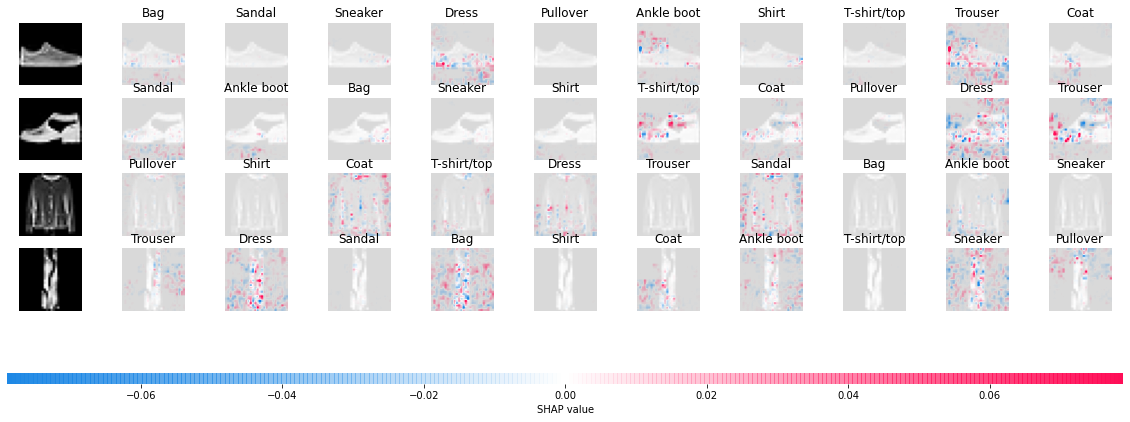

In [31]:
wrong_preds_idx = np.argwhere(Y_test!=Y_test_preds)
X_batch = X_test[wrong_preds_idx.flatten()[:4]]
Y_batch = Y_test[wrong_preds_idx.flatten()[:4]]
print("Actual Labels    : {}".format([mapping[i] for i in Y_batch]))
probs = model.predict(X_batch)
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)
explainer = shap.PermutationExplainer(model, masker, output_names=class_labels)
shap_values = explainer(X_batch, max_evals=1600, outputs=shap.Explanation.argsort.flip[:5])
print(shap_values.shape)
Y_preds = model.predict(X_batch)
Y_preds = Y_preds.argsort()[:, ::-1]
Y_labels = [[class_labels[val] for val in row] for row in Y_preds]
Y_labels=np.array(Y_labels)
print(Y_labels)
shap.image_plot(shap_values, labels=Y_labels)

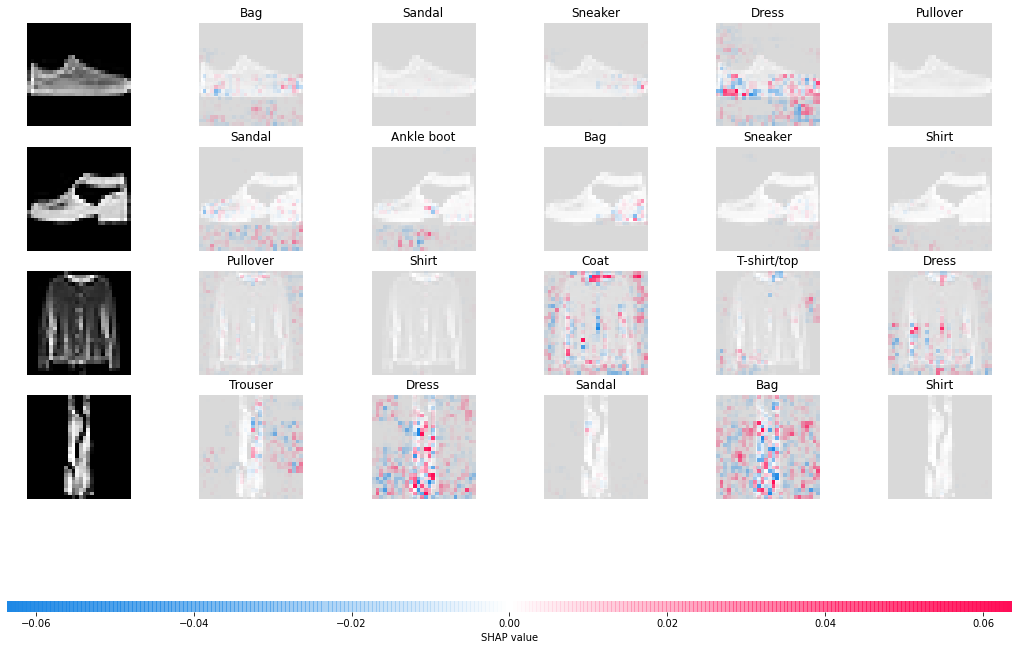

In [32]:
shap.image_plot(shap_values[:,:,:,:,:5], labels=Y_labels[:,:5])